# OSMNX

In [20]:
import sys
sys.path.insert(0, r'../../../quetzal')

import geopandas as gpd
from shapely import geometry
import osmnx as ox
import geopandas as gpd
import os

from syspy.spatial.graph.graphbuilder import GraphBuilder, OsmnxCleaner
from syspy.spatial.graph import graphbuilder

training_folder = '../../'
input_folder = training_folder + r'inputs/'

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 9]

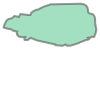

In [22]:
zones = gpd.read_file(r'../../inputs/zones/zones.geojson')
hull = geometry.MultiPolygon(zones['geometry'].values).buffer(1e-3)
hull

# OSMNX API

In [23]:
drive = ox.graph_from_polygon(hull)

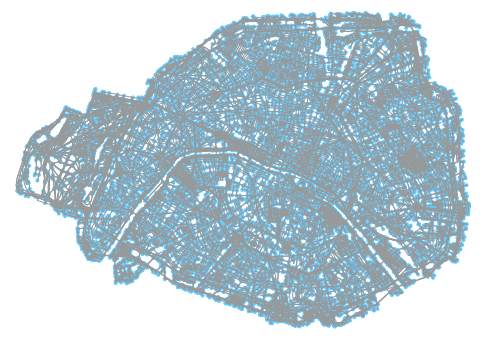

In [24]:
plot = ox.plot_graph(drive)

In [25]:
road_nodes, road_links = ox.graph_to_gdfs(drive)

In [26]:
road_links.rename(columns={'u': 'from', 'v': 'to'}, inplace=True)
road_nodes['osmid'] = road_nodes['osmid'].astype(str)
road_nodes = road_nodes.set_index('osmid')[['geometry']]
road_links[['from', 'to']] = road_links[['from', 'to']].astype(str)

# cleaning

In [27]:
from shapely import geometry
def simplify_link(g):
    l = list(g.coords)
    return geometry.LineString([l[0], l[-1]])

In [28]:
road_links['geometry'] = road_links['geometry'].apply(simplify_link)
oc = OsmnxCleaner(
    road_links, 
    road_nodes, 
    a='from', 
    b='to'
)

In [29]:
oc.add_reversed_links(
    direction_column='oneway', 
    reverse_value=False # the boolean has been stored as a string    
)
oc.clean_geometries()
oc.fix_nodeset_consistency()

# export 

In [30]:
from quetzal.model.stepmodel import StepModel

sm = StepModel(epsg=4326, coordinates_unit='degree')
sm.road_links = oc.links[['a', 'b', 'length', 'geometry', 'highway']].copy()
sm.road_nodes = oc.nodes[['geometry']].copy()

In [31]:
sm.road_links['highway'] = sm.road_links['highway'].astype(str)
irrelevant = ['pedestrian', 'footway', 'service', 'cycleway']
sm.road_links = sm.road_links.loc[~sm.road_links['highway'].isin(irrelevant)]

In [32]:
sm.to_json(input_folder + 'road', only_attributes=['road_links', 'road_nodes'])

to_hdf(overwriting): 100%|█████████████████████████████████████████████████████████████| 32/32 [00:13<00:00,  2.30it/s]


In [33]:
sm.to_json(input_folder + 'road', only_attributes=['road_links', 'road_nodes'])

to_hdf(overwriting): 100%|█████████████████████████████████████████████████████████████| 32/32 [00:13<00:00,  2.32it/s]
